In [1]:
import pandas as pd
import re
from datetime import date
from tqdm import tqdm
from utilities.utils import wspex, tofloat, percentile, get_parse_date_srs
import matplotlib.pyplot as plt
import pandas as pd
from utilities.base import BaseData

# wspex, tofloat, percentile

sfb = pd.read_csv('/Users/user/PycharmProjects/ane_django/parser_app/logic/description/sfb.csv', sep=';')

def price_coef(id_n, string_unit):  # основано на весах 33 категорий условного минимального набора товаров и услуг
    # столбик весов - перевод в нужные единицы веса - перевод в стоимость через коэффициент
    # print(string_unit)
    global sfb
    kg_units = ['кг', 'kg', 'килограмм']
    g_units = ['г', 'g', 'грамм', 'граммов', 'гр']  # в кг
    litre_units = ['л', 'l', 'литр', 'литров', 'литра']
    ml_units = ['мл', 'ml', 'миллилитров', 'миллилитра']
    amount = float(re.search('\d+(\.\d*){0,1}', string_unit)[0])
    unit = re.search('[а-яa-z]+', string_unit)[0]

    if unit in g_units or unit in ml_units:
        coeff = 1000 / amount
    elif unit in kg_units or unit in litre_units:
        coeff = 1 / amount
    elif unit == 'шт':
        coeff = 10 / amount
    else:
        raise ValueError('Unit {} from string_unit {} is unknown'.format(unit, string_unit))
    coeff = coeff * sfb[sfb.id == id_n].req_amount.iloc[0]
    return coeff / 12

def pack_to_gramm(string):  # перевод в граммы для (50×2г)
    pattern_1 = re.compile('\d+\s{0,1}(пак){0,1}\s{0,1}(?:\*|×|x|х)')
    pattern_2 = re.compile('(?:\*|×|x|х)\s{0,1}\d+\,{0,1}\d*\s*г')
    pattern_3 = re.compile('\d+(?:\,|\.){0,1}\d*\s*г(?:\*|×|x|х)')
    pattern_4 = re.compile('(?:\*|×|x|х)\s{0,1}\d+\s{0,1}(пак){0,1}')

    if re.search(pattern_1, string) != None and re.search(pattern_2, string) != None:
        return str(int(wspex(re.search('\d+', ((re.search(pattern_1, string)[0])[:-1]))[0])) * tofloat(
            re.search(pattern_2, string)[0][1:-1])) + 'г'
    if re.search(pattern_3, string) != None and re.search(pattern_4, string) != None:
        return str(int(wspex(re.search('\d+', ((re.search(pattern_4, string)[0])))[0])) * tofloat(
            wspex(re.search(pattern_3, string)[0])[:-2])) + 'г'
    
def get_basket_df(df_retail, date=date(2019, 3, 1)):
    # print('get basket df...')
   
    # онлайн-проды
    # df_retail = df_retail.drop('id', axis=1)
#     df_retail = df_retail.drop('level_0', axis=1)
    df_retail.loc[:, 'date'] = pd.to_datetime(df_retail.date)
    df = pd.concat([df_retail], join='inner')

    df = df.drop_duplicates(subset=['date', 'site_title', 'site_link']).reset_index(drop=True)

    df_new = df.loc[df.date >= pd.Timestamp(date), :]
    grouped = df_new.groupby(['category_id', 'site_code', 'site_link']).nunique()[['date']]
    grouped = grouped.loc[grouped.date == max(grouped.date), :]
    links = grouped.index.get_level_values(level=2)
    # подготовленный датафрейм (только те товары, которые наблюдались с 1 июля 2019 и по сегодня)
    df_new = df_new[df_new.site_link.isin(links)]
    # weight

    piece_units = ['шт', 'штук', 'штуки', 'штука', 'пак', 'пакетиков', 'пак']
    kg_units = ['кг', 'kg', 'килограмм']  # оставить в граммах
    gram_units = ['г', 'g', 'грамм', 'граммов', 'гр']  # в кг
    litre_units = ['л', 'l', 'литр', 'литров', 'литра']
    ml_units = ['мл', 'ml', 'миллилитров', 'миллилитра']
    tenpiece_units = ['10 шт', '10 шт.', '10шт', '10шт.', 'десяток', 'дес.']

    kg_pattern = r'\s*(?:\d{1,4}[×,.]\d{1,4}|\d{1,4})\s*(?:' + r'|'.join(kg_units) + r')'
    g_pattern = r'\s*(?:\d{1,4}[×,.]\d{1,4}|\d{1,4})\s*(?:' + r'|'.join(gram_units) + r')'
    l_pattern = r'\s*(?:\d{1,4}[×,.]\d{1,4}|\d{1,4})\s*(?:' + r'|'.join(litre_units) + r')'
    ml_pattern = r'\s*(?:\d{1,4}[×,.]\d{1,4}|\d{1,4})\s*(?:' + r'|'.join(ml_units) + r')'
    piece_pattern = r'\s*(?:\d{1,4}[×,.]\d{1,4}|\d{1,4})\s*(?:' + r'|'.join(piece_units) + r')'
    tenpiece_pattern = r'\s*(?:\d{1,4}[×,.]\d{1,4}|\d{1,4})\s*(?:' + r'|'.join(tenpiece_units) + r')'

    patterns = [piece_pattern, tenpiece_pattern, kg_pattern, g_pattern, l_pattern, ml_pattern]
    df_new['weight'] = None

    for title in tqdm(df_new.site_title.unique()):
        for pattern in patterns:
            match = re.search(pattern, title.lower())
            if match:
                df_new.loc[df_new.site_title == title, 'weight'] = match[0]
    df_new.loc[df_new.weight.isna(), 'weight'] = df_new.loc[df_new.weight.isna(), 'site_unit']
    df_new.loc[df_new.site_unit.isin(['за 1 кг', 'кг', 'за 100 г']), 'weight'] = df_new.loc[
        df_new.site_unit.isin(['за 1 кг', 'кг', 'за 100 г']), 'weight'].apply(lambda x: wspex(x).replace('за', ''))
    df_new.loc[df_new.weight == 'кг', 'weight'] = '1кг'
    df_new.loc[df_new.site_unit == 'кг', 'weight'] = '1кг'

    # weight only

    df_new.loc[:,'weight'] = df_new.weight.apply(lambda x: wspex(x.replace('\xa0', '')) if x is not None else x)

    df_new.loc[:,'weight']  = df_new.weight.apply(lambda x: x.replace(',', '.') if ',' in x else x)
    pattern1 = re.compile('\d+\s{0,1}(пак){0,1}\s{0,1}(?:\*|×|x|х)\s{0,1}\d+\,{0,1}\d*\s*г')
    pattern2 = re.compile('\d+(?:\,|\.){0,1}\d*\s*г(?:\*|×|x|х)\s{0,1}\d+\s{0,1}(пак){0,1}')
    df_new.loc[:,'weight']  = df_new.apply(
        lambda x: pack_to_gramm(x['site_title']) if re.search(pattern1, x['site_title']) != None or re.search(pattern2,
                                                                                                              x[
                                                                                                                  'site_title']) is not None
        else x['weight'], axis=1)

    dict_pack = {'25пак': '50г', '20пак': '80г', '100пак': '200г', 'л': '1л', '010шт': '10шт.',
                 '2019кг': '1кг', '110шт': '10шт', '210шт': '10шт'}

    df_new.loc[:,'weight']  = df_new.weight.replace(dict_pack)
    df_new.loc[(df_new.weight == '4l') & (df_new.type == 'food'), 'weight'] = df_new.loc[
        (df_new.weight == '4l') & (df_new.type == 'food'), 'site_unit'].apply(lambda x: wspex(x).replace(',', '.'))
    df_new.loc[df_new.site_title == 'Соль поваренная пищевая каменная помол №1', 'weight'] = '1кг'
    df_new = df_new[df_new.site_title.str.contains('Огурцы длинноплодные шт') == False]
    df_new = df_new[df_new.weight != '1шт']
    non_sht = df_new.loc[
        (df_new.site_title.str.contains(re.compile('Яйц(?:о|а)')) == False) & (df_new.weight.str.contains('шт')) & (
                    df_new.type == 'food')].site_link.unique()
    df_new = df_new[df_new.site_link.isin(non_sht) == False]
    df_new.loc[:, 'coef'] = None
    # df_new.loc[df_new.nsprice_f==-1.0,'nspices_f']=0
    for id_n in tqdm(df_new.category_id.unique()):
        for unit in df_new.loc[df_new.category_id == id_n].weight.unique():
            df_new.loc[(df_new.category_id == id_n) & (df_new.weight == unit), 'coef'] = price_coef(id_n, unit)

    df_new.loc[:, 'price_bsk'] = df_new.loc[:, 'coef'] * df_new.loc[:, 'nsprice_f']
    df_new.loc[:, 'price_bsk'] = df_new.loc[:, 'price_bsk'].astype(float)
    df_new = df_new.drop_duplicates(subset=['date', 'site_title', 'site_code'])

    basket_df = pd.DataFrame()

    basket_df.loc[:, 'basket_online'] = \
        df_new[df_new.site_code != 'gks'].groupby(['date', 'category_id']).agg(percentile(25)).groupby(level=0).sum()[
            'price_bsk']
    basket_df = basket_df.reset_index().reset_index().rename(columns={'index': 'id'}).set_index('id')
    print('completed!')
    return basket_df

In [2]:
filled_df = BaseData().get_filled_df()

In [3]:
basket_online = get_basket_df(filled_df.loc[filled_df.category_id.isin(range(1, 34)), :])
basket_online = basket_online.set_index('date')

/Users/user/Desktop/RANEPA_lec_24_03/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
100%|██████████| 30/30 [00:04<00:00,  6.68it/s]
/var/folders/c0/88ft1w2s0j58fqydt5bs54bh0000gn/T/ipykernel_3195/2182831303.py:135: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  df_new[df_new.site_code != 'gks'].groupby(['date', 'category_id']).agg(percentile(25)).groupby(level=0).sum()[


completed!


In [4]:

basket_gks = pd.read_excel('~/Downloads/data.xls',header=1, skiprows=0, sheet_name='Данные')

basket_gks.columns = ['year', 'month', 'basket_gks']
basket_gks.loc[:,'date'] = get_parse_date_srs(basket_gks.month + basket_gks.year.astype(str))

basket_gks = basket_gks.drop(columns=['year', 'month'])
basket_gks = basket_gks.set_index('date')
basket_gks = basket_gks.reindex(basket_online.index, method='ffill')
basket_gks.tail()


/Users/user/Desktop/RANEPA_lec_24_03/venv/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


,basket_gks
date,
2023-11-27,6890.1
2023-11-28,6890.1
2023-11-29,6890.1
2023-11-30,6890.1
2023-12-01,6890.1


# Корзина Онлайн VS Росстат

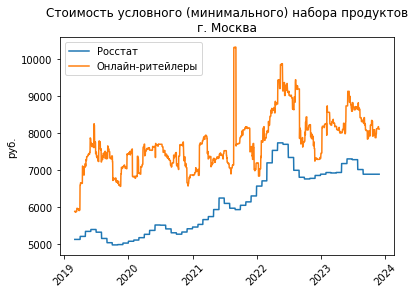

In [5]:
plt.plot(basket_gks);
plt.plot(basket_online-200);
plt.title('Стоимость условного (минимального) набора продуктов\nг. Москва');
plt.ylabel('руб.');
plt.xticks(rotation=45);
plt.legend(['Росстат','Онлайн-ритейлеры']);
plt.savefig("./plots/basket_online_vs_rosstat.pdf", bbox_inches='tight')

In [6]:
basket_gks.merge(basket_online, left_on='date', right_on='date', how='inner').to_excel('./plots/basket_price.xlsx')

In [7]:
basket_gks.merge(basket_online, left_on='date', right_on='date', how='inner').resample('M').first().to_excel('./plots/basket_month_price.xlsx')